# Practice Model: A Simple Starter
### Building a GP where 

$
\begin{align}
\Delta \nu \sim \mathcal{GP}(f(mass), k(mass,mass^{\prime}))
\end{align}
$

We'll start out by using `numpy` as a test to prove to ourselves that we understand GP implementations in general.

> We are looking for the functional form so that we can implement the likelihood calculation later.  
The independent parameter is mass and the observed is $\Delta$$\nu$

***

### Some assumptions
In the first place, since this is a "simple" starter model, we can make some decisions before we even start to guide the process of implementing the model. Let's start with a fairly common GP, where the mean function is zero and the covariance function is a squared exponential. Why? Because that's where everyone starts from.

This squared exponential says that values of $mass$ and $mass^\prime$ that are close to each other result in values of $k$ closer to 1. This ends up looking like a diagonal covariance matrix. 

Let's talk about why that makes sense -HERE-

***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Our observed value is $\Delta$$\nu$ - for now we'll call it `Dnu` for ease of typing  
Our independent parameter is `mass` - this is a perfectly fine variable name, but remember that if you're following a tutorial for more complicated GP implementations, it's likely to be called $x$ 

Let's have a look at the dataset given:

In [221]:
data = np.loadtxt('./Lindsey_version1.csv', delimiter=',', skiprows=1)
Dnu = data[:,1]
mass = data [:, 0]

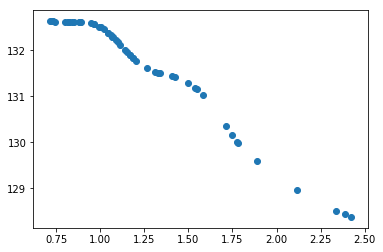

In [185]:
# TODO: Make this not as awful
fig, ax = plt.subplots()
ax.scatter(mass, Dnu)

What we think we see in this plot is a relationship between stellar mass and observed $\Delta$$\nu$.  
That is, this plot looks like it's trying to inform us that the large frequency separation decreases as stellar mass increases  
It's also a really bad looking plot, but `TODO`: fix it later  

*** 

Our goal is to try to find a good (even if it's wrong) posterior estimate of the functional form.  
Posterior estimate: "the shaded region" <- what I think of as 'the area under the curve' except it's a space shaped by the mean function, constrained by observed points, and bounded by the standard deviation

***

### Gaussian process in numpy

_Step 1: Start with a prior_  
_Step 2: Compute the posterior_  
_Step 3: Sample and compare_  

 [ ] Construct a vector of test inputs evenly spaced so as to seem continuous ($X$$_*$, or mass$_*$)  
 [ ] Define the kernel function - Squared Exponential kernel  
 [ ] Figure out the hyperparameters $\sigma$$_f$$^2$ and length scale  
 [ ] Use the kernel function to create the matrices for computing the covariance and the mean of the posterior ($cov$($f_*$) & $\mu$)  
 

***

### Some useful definitions before we move on:
##### Hyperparameter:
parameters of the covariance function; $\theta$ is often used to represent this in formulae?

##### Overfitting/Overfitted Model:
a statistical model that contains more parameters than are justified by the data; a model that "memorizes" training data instead of "learning" a trend

##### Placeholer:
some thing that I would benefit from having a definition that's easy to flip back to in moments of foggy understanding

In [186]:
# What if the issue is that the observerd values need to be normalized?
from sklearn.preprocessing import normalize

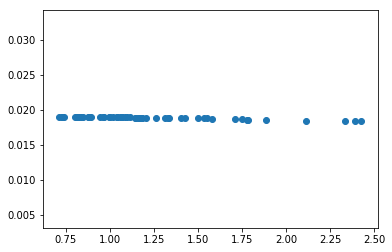

In [187]:
Dnu = normalize(Dnu[:,np.newaxis], norm='l1', axis=0).ravel()#l2 by default

# TODO: Make this not as awful
fig, ax = plt.subplots()
ax.scatter(mass, Dnu)

In [348]:
# there are 53 points of data, so let's try 1k test points in the vector?
n = 8000
x_s = np.linspace(0.7, 2.5, n) # ranged from np.min(mass) to np.max(mass) with wiggle

# just call the hyperparameters what they are because there's no need to be so obfuscating folks
sigma2 =  3 # variance of the (noise free) signal; as latex $\sigma$$_f$$^2$
length_scale = 10

Placeholder for an informative comment

In [349]:
def exponential_cov(x, x_p, sig2, ls):
    return sig2 * np.exp( -1/(2*ls**2)*np.abs(x[:,np.newaxis]-x_p[:,np.newaxis ].T)**2)

Placeholder for an informative comment

In [350]:
# Generally I prefer the A,B,C format, but it became harder to see the references at a glance later
Kss = exponential_cov(x_s ,x_s,sigma2,length_scale)
Ks = exponential_cov(mass,x_s,sigma2,length_scale)
K = exponential_cov(mass,mass,sigma2,length_scale)

Placeholder for an informative comment

In [ ]:
mu_post = (Ks.T@np.linalg.inv(K))@Dnu
K_post = Kss - Ks.T@np.linalg.inv(K)@Ks

Yet another placeholder for an informative comment!

In [ ]:
s = 25
K = exponential_cov(mass,mass,sigma2,length_scale) + 0.1* np.eye(len(mass))
mu_post = (Ks.T@np.linalg.inv(K))@(Dnu)
K_post = Kss - Ks.T@np.linalg.inv(K)@Ks
fs = multivariate_normal (mean=mu_post ,cov=K_post , allow_singular =True).rvs(s).T

In [ ]:
plt.plot(x_s ,fs ,'gray') # Plot the samples
plt.scatter(mass,Dnu,zorder =3)
plt.title('l = sqrt(2), with noise')
plt.show ()
plt.plot(x_s ,mu_post ,'black') 
# Plot credibility regions
plt. fill_between (x_s ,mu_post + 3*np.sqrt(np.diag(K_post)),mu_post - 3*np.sqrt(np.diag(K_post)),color='lightgray')
plt. fill_between (x_s ,mu_post + 2*np.sqrt(np.diag(K_post)),mu_post - 2*np.sqrt(np.diag(K_post)),color='darkgray')
plt. fill_between (x_s ,mu_post + 1*np.sqrt(np.diag(K_post)),mu_post - 1*np.sqrt(np.diag(K_post)),color='gray')
plt.scatter(mass,Dnu,zorder =3)
plt.title('l = sqrt(2), with noise')
plt.show ()